## Section 1: Imports and Reading Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import transformers
from transformers import BertModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Reading Data
df = pd.read_csv("data.csv")
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)

## Section 2: Preprocessing and Tokenization

In [3]:
# Remove rows with null values
df = df.dropna()

# Tokenization
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_test_final, y_train, y_test_final = train_test_split(df.Sentence.values, labels, test_size=0.1, stratify=df.Sentiment.values)

## Section 3: Dataset Class

In [4]:
# Dataset Class
class Datagen(Dataset):
    def __init__(self, sentence, target, tokenizer, max_len):
        self.sentence = sentence
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        bert_encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            "input_ids": torch.squeeze(bert_encoding["input_ids"]),
            "attention_mask": torch.squeeze(bert_encoding["attention_mask"]),
            "target": torch.tensor(self.target[idx], dtype=torch.long)
        }


## Section 4: Model Parameters

In [5]:
class SentimentModel(nn.Module):
    def __init__(self, n_class):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_class)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentModel(n_class=3)
model = model.to(torch.device('cuda'))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Section 5: Helper Functions

In [6]:
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

def accuracy(dataloader, model):
    model.eval()
    batch_acc = 0
    for inputs in dataloader:
        to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
        input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

        outputs = model(input_ids, attention_mask)
        prediction = outputs.argmax(dim=1)
        acc = check_acc(prediction, target)
        batch_acc += acc
    return batch_acc/len(dataloader)


## Section 6: Training with Cross-Validation

In [8]:
num_epochs = 10
skf = StratifiedKFold(n_splits=2, shuffle=True)
cv_fold_acc = []
cv_epoch_acc = []

# Lists to store training and validation loss
train_losses = []
cv_losses = []


for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/{skf.get_n_splits()}")

    X_train, X_temp = X_train[train_index], X_train[test_index]
    y_train, y_temp = y_train[train_index], y_train[test_index]

    # Further split the test set into cv and test
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

    train_data = Datagen(X_train, y_train, tokenizer, 50)
    cv_data = Datagen(X_cv, y_cv, tokenizer, 50)
    test_data = Datagen(X_test, y_test, tokenizer, 50)

    train_dataloader = DataLoader(train_data, batch_size=16, num_workers=2)
    cv_dataloader = DataLoader(cv_data, batch_size=15, num_workers=2)
    test_dataloader = DataLoader(test_data, batch_size=15, num_workers=2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_dataloader))

    with torch.no_grad():
        torch.cuda.empty_cache()
    # Create a new instance of the model for each fold
    model = SentimentModel(n_class=3)  # Replace YourModel with the actual class or function to create your model
    model.to(torch.device('cuda'))

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation loss for each fold
    all_train_losses = []
    all_cv_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for steps, inputs in enumerate(train_dataloader):
            to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
            input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        train_losses.append(average_loss)  # Save training loss

        train_acc = accuracy(train_dataloader, model)
        cv_acc = accuracy(cv_dataloader, model)
        cv_epoch_acc.append(cv_acc)
        
        print(f"Fold {fold + 1}/{skf.get_n_splits()}\t Epoch: {epoch}\t Train accuracy: {train_acc}\t CV accuracy: {cv_acc}")

        scheduler.step() 
    
    cv_fold_acc.append(cv_epoch_acc[-1])
    cv_loss = criterion(outputs, target).item()  # Calculate validation loss
    cv_losses.append(cv_loss)  # Save validation loss

    all_train_losses.append(train_losses)
    all_cv_losses.append(cv_losses)

print(f"Average CV accuracy: {np.mean(cv_fold_acc)}")
# Best CV accuracy:
print(f"Best CV accuracy: {np.max(cv_fold_acc)}")

# Worst CV accuracy:
print(f"Worst CV accuracy: {np.min(cv_fold_acc)}")


Fold 1/2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 1/2	 Epoch: 0	 Train accuracy: 0.7650602409638554	 CV accuracy: 0.6795454545454548


/home/apo-pc/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Fold 1/2	 Epoch: 1	 Train accuracy: 0.8516566265060241	 CV accuracy: 0.7276515151515155
Fold 1/2	 Epoch: 2	 Train accuracy: 0.9096385542168675	 CV accuracy: 0.7731060606060609
Fold 1/2	 Epoch: 3	 Train accuracy: 0.9239457831325302	 CV accuracy: 0.7962121212121217
Fold 1/2	 Epoch: 4	 Train accuracy: 0.9518072289156626	 CV accuracy: 0.7840909090909096
Fold 1/2	 Epoch: 5	 Train accuracy: 0.9615963855421686	 CV accuracy: 0.7750000000000004
Fold 1/2	 Epoch: 6	 Train accuracy: 0.9525602409638554	 CV accuracy: 0.7931818181818184
Fold 1/2	 Epoch: 7	 Train accuracy: 0.9563253012048193	 CV accuracy: 0.7931818181818184
Fold 1/2	 Epoch: 8	 Train accuracy: 0.9698795180722891	 CV accuracy: 0.7840909090909093
Fold 1/2	 Epoch: 9	 Train accuracy: 0.973644578313253	 CV accuracy: 0.7901515151515155
Fold 2/2


IndexError: index 1319 is out of bounds for axis 0 with size 1314

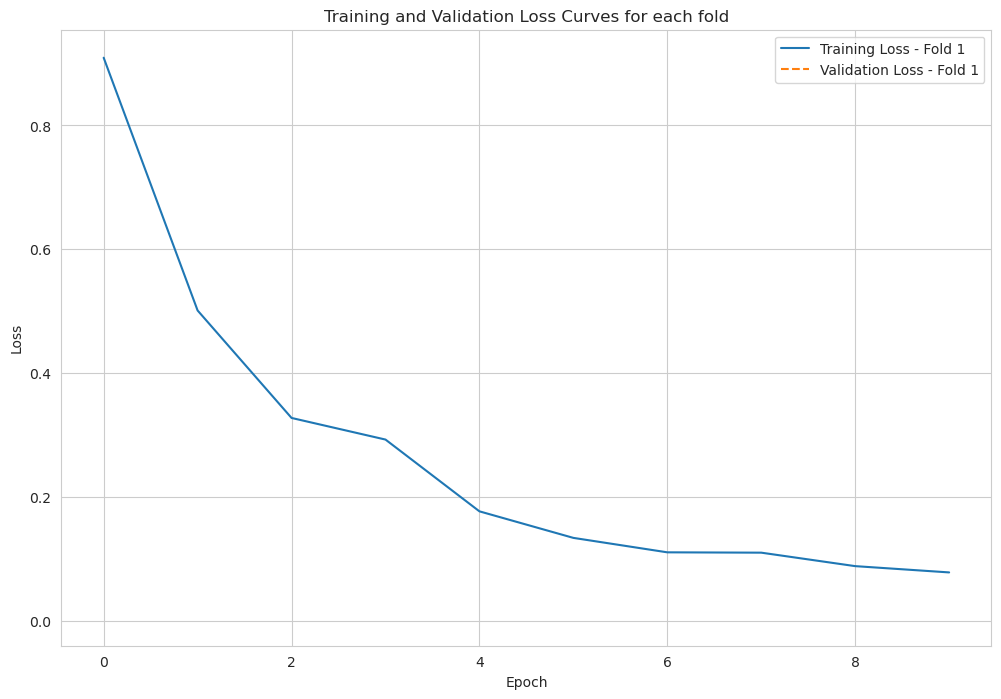

In [9]:
# Plotting Training and Validation Loss Curves for each fold
plt.figure(figsize=(12, 8))
for fold in range(len(all_train_losses)):
    plt.plot(all_train_losses[fold], label=f'Training Loss - Fold {fold + 1}')
    plt.plot(all_cv_losses[fold], label=f'Validation Loss - Fold {fold + 1}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for each fold')
plt.legend()
plt.show()


## Section 7: Testing

Test accuracy: 0.7424242424242427
              precision    recall  f1-score   support

           0       0.36      0.32      0.34        97
           1       0.77      0.84      0.81       352
           2       0.86      0.77      0.81       208

    accuracy                           0.74       657
   macro avg       0.66      0.64      0.65       657
weighted avg       0.74      0.74      0.74       657


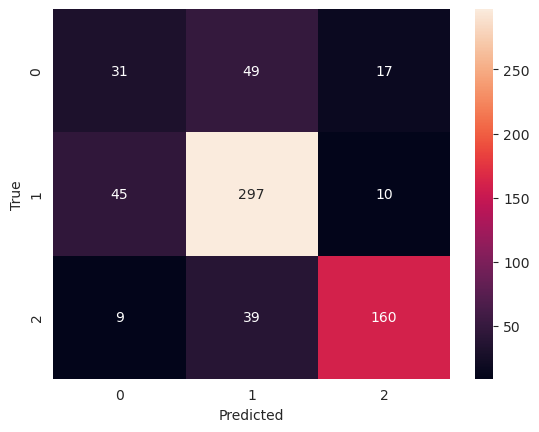

In [10]:
# Testing
model.eval()
test_acc = accuracy(test_dataloader, model)
print(f"Test accuracy: {test_acc}")

# Metrics for classification, use this to get precision, recall, f2 from sklearn.metrics import classification_report, using cpu.
from sklearn.metrics import classification_report

y_pred = []
y_true = []
for inputs in test_dataloader:
    to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
    input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

    outputs = model(input_ids, attention_mask)
    prediction = outputs.argmax(dim=1)
    y_pred.extend(prediction.cpu().numpy())
    y_true.extend(target.cpu().numpy())
    
print(classification_report(y_true, y_pred))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Section 8: Saving the Model

In [15]:
# Saving the model
torch.save(model.state_dict(), "model_otp.pt")

In [ ]:
# Plotting Confusion Matrix

In [14]:
del model
import gc
gc.collect()
torch.cuda.empty_cache() # PyTorch thing
